In [1]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("Retail-Capstone").getOrCreate()
sc = spark.sparkContext

customers_data = [
    (1, "Rahul Sharma", "Bangalore", 28),
    (2, "Priya Singh", "Delhi", 32),
    (3, "Aman Kumar", "Hyderabad", 25),
    (4, "Sneha Reddy", "Chennai", 35),
    (5, "Arjun Mehta", "Mumbai", 30),
    (6, "Divya Nair", "Delhi", 29)
]
customers_cols = ["customer_id", "name", "city", "age"]
customers_df = spark.createDataFrame(customers_data, customers_cols)

products_data = [
    (101, "Laptop", "Electronics", 55000),
    (102, "Mobile", "Electronics", 25000),
    (103, "Headphones", "Electronics", 3000),
    (104, "Chair", "Furniture", 5000),
    (105, "Book", "Stationery", 700),
    (106, "Shoes", "Fashion", 2500)
]
products_cols = ["product_id", "product_name", "category", "price"]
products_df = spark.createDataFrame(products_data, products_cols)

orders_data = [
    (1001, 1, 101, 1, "2024-01-10"),
    (1002, 2, 102, 2, "2024-01-12"),
    (1003, 1, 103, 3, "2024-02-05"),
    (1004, 3, 104, 1, "2024-02-08"),
    (1005, 5, 105, 5, "2024-03-01"),
    (1006, 6, 106, 2, "2024-03-15"),
    (1007, 7, 101, 1, "2024-03-20")
]
orders_cols = ["order_id", "customer_id", "product_id", "quantity", "order_date"]
orders_df = spark.createDataFrame(orders_data, orders_cols)

In [2]:
# 1
numbers = [10, 20, 30, 40, 50]
num_rdd = sc.parallelize(numbers)
print(num_rdd.sum(), num_rdd.max(), num_rdd.min(), num_rdd.mean())
# 2
sentences = ["hello world", "hello spark", "spark with pyspark"]
rdd = sc.parallelize(sentences).flatMap(lambda s: s.split(" "))
word_count = rdd.map(lambda w: (w,1)).reduceByKey(lambda a,b: a+b)
print(word_count.collect())

150 50 10 30.0
[('hello', 2), ('world', 1), ('with', 1), ('spark', 2), ('pyspark', 1)]


In [3]:
# 3
customers_df.select("name","city").show()
# 4
customers_df.filter(customers_df.age > 30).show()
# 5
products_df.select("category").distinct().show()
# 6
products_df.orderBy(F.desc("price")).limit(3).show()

+------------+---------+
|        name|     city|
+------------+---------+
|Rahul Sharma|Bangalore|
| Priya Singh|    Delhi|
|  Aman Kumar|Hyderabad|
| Sneha Reddy|  Chennai|
| Arjun Mehta|   Mumbai|
|  Divya Nair|    Delhi|
+------------+---------+

+-----------+-----------+-------+---+
|customer_id|       name|   city|age|
+-----------+-----------+-------+---+
|          2|Priya Singh|  Delhi| 32|
|          4|Sneha Reddy|Chennai| 35|
+-----------+-----------+-------+---+

+-----------+
|   category|
+-----------+
|Electronics|
| Stationery|
|    Fashion|
|  Furniture|
+-----------+

+----------+------------+-----------+-----+
|product_id|product_name|   category|price|
+----------+------------+-----------+-----+
|       101|      Laptop|Electronics|55000|
|       102|      Mobile|Electronics|25000|
|       104|       Chair|  Furniture| 5000|
+----------+------------+-----------+-----+



In [4]:
# 7
customers_df.groupBy("city").agg(F.avg("age").alias("avg_age")).show()
# 8
orders_with_price = orders_df.join(products_df, "product_id") \
                             .withColumn("revenue", F.col("quantity")*F.col("price"))
orders_with_price.groupBy("product_name").agg(F.sum("revenue").alias("total_revenue")).show()
# 9
orders_df.groupBy("product_id").agg(F.sum("quantity").alias("total_sold")) \
    .orderBy(F.desc("total_sold")).limit(1).show()

+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   28.0|
|    Delhi|   30.5|
|Hyderabad|   25.0|
|  Chennai|   35.0|
|   Mumbai|   30.0|
+---------+-------+

+------------+-------------+
|product_name|total_revenue|
+------------+-------------+
|       Chair|         5000|
|        Book|         3500|
|      Laptop|       110000|
|       Shoes|         5000|
|      Mobile|        50000|
|  Headphones|         9000|
+------------+-------------+

+----------+----------+
|product_id|total_sold|
+----------+----------+
|       105|         5|
+----------+----------+



In [5]:
# 10
customers_df.join(orders_df, "customer_id", "inner").show()
# 11
orders_df.join(products_df, "product_id", "inner").show()
# 12
customers_df.join(orders_df, "customer_id", "left_anti").show()
# 13
products_df.join(orders_df, "product_id", "left_anti").show()

+-----------+------------+---------+---+--------+----------+--------+----------+
|customer_id|        name|     city|age|order_id|product_id|quantity|order_date|
+-----------+------------+---------+---+--------+----------+--------+----------+
|          1|Rahul Sharma|Bangalore| 28|    1001|       101|       1|2024-01-10|
|          1|Rahul Sharma|Bangalore| 28|    1003|       103|       3|2024-02-05|
|          2| Priya Singh|    Delhi| 32|    1002|       102|       2|2024-01-12|
|          3|  Aman Kumar|Hyderabad| 25|    1004|       104|       1|2024-02-08|
|          5| Arjun Mehta|   Mumbai| 30|    1005|       105|       5|2024-03-01|
|          6|  Divya Nair|    Delhi| 29|    1006|       106|       2|2024-03-15|
+-----------+------------+---------+---+--------+----------+--------+----------+

+----------+--------+-----------+--------+----------+------------+-----------+-----+
|product_id|order_id|customer_id|quantity|order_date|product_name|   category|price|
+----------+-------

In [6]:
# 14
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_df.createOrReplaceTempView("orders")
# 15
spark.sql("""
    SELECT c.city, SUM(o.quantity*p.price) AS total_revenue
    FROM orders o
    JOIN customers c ON o.customer_id=c.customer_id
    JOIN products p ON o.product_id=p.product_id
    GROUP BY c.city
    ORDER BY total_revenue DESC
    LIMIT 2
""").show()
# 16
spark.sql("""
    SELECT c.name, SUM(o.quantity*p.price) AS total_spent
    FROM orders o
    JOIN customers c ON o.customer_id=c.customer_id
    JOIN products p ON o.product_id=p.product_id
    GROUP BY c.name
    HAVING total_spent > 50000
""").show()
# 17
spark.sql("""
    SELECT p.category, SUM(o.quantity*p.price) AS revenue
    FROM orders o
    JOIN products p ON o.product_id=p.product_id
    GROUP BY p.category
    ORDER BY revenue DESC
    LIMIT 1
""").show()

+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|Bangalore|        64000|
|    Delhi|        55000|
+---------+-------------+

+------------+-----------+
|        name|total_spent|
+------------+-----------+
|Rahul Sharma|      64000|
+------------+-----------+

+-----------+-------+
|   category|revenue|
+-----------+-------+
|Electronics| 169000|
+-----------+-------+



In [7]:
# 18
orders_df.write.mode("overwrite").csv("/content/orders_csv", header=True)
# 19
orders_loaded = spark.read.csv("/content/orders_csv", header=True, inferSchema=True)
# 20
products_df.write.mode("overwrite").json("/content/products_json")
products_loaded = spark.read.json("/content/products_json")

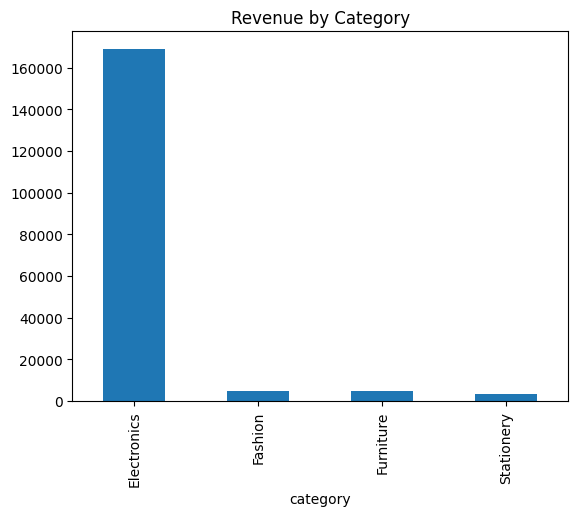

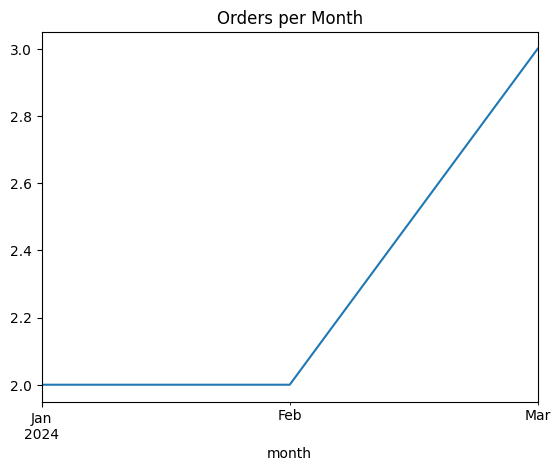

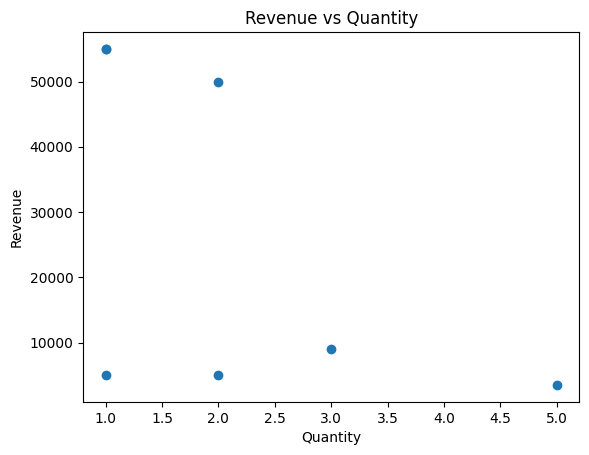

In [8]:
# 21
orders_with_price_pd = orders_with_price.toPandas()
# 22
rev_by_cat = orders_with_price_pd.groupby("category")["revenue"].sum()
rev_by_cat.plot(kind="bar", title="Revenue by Category")
plt.show()
# 23
orders_with_price_pd["month"] = pd.to_datetime(orders_with_price_pd["order_date"]).dt.to_period("M")
orders_per_month = orders_with_price_pd.groupby("month")["order_id"].count()
orders_per_month.plot(kind="line", title="Orders per Month")
plt.show()
# 24
plt.scatter(orders_with_price_pd["quantity"], orders_with_price_pd["revenue"])
plt.xlabel("Quantity")
plt.ylabel("Revenue")
plt.title("Revenue vs Quantity")
plt.show()